Make sure the following dependencies are installed. Feel free to save in a `requirements.txt` file.

```
colabfold @ git+https://github.com/sokrypton/ColabFold@main
alphafold
py3Dmol
matplotlib
biopython
numpy==1.19.0
pandas
torch
```

In [2]:
import os
import re
import hashlib
from sys import version_info

# Helper function to add hash to jobname based on the sequence
def add_hash(x: str, y: str) -> str:
    """
    Add a hash to the jobname based on the input sequence.

    Parameters:
    - x: The base jobname.
    - y: The sequence to hash.

    Returns:
    - A new jobname with the hash appended.
    """
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

# Helper function to check if a folder exists
def check_folder_exists(folder: str) -> bool:
    """
    Check if the folder already exists.

    Parameters:
    - folder: The folder path.

    Returns:
    - True if folder does not exist, False otherwise.
    """
    return not os.path.exists(folder)

# Function to sanitize the jobname
def sanitize_jobname(jobname: str) -> str:
    """
    Sanitize jobname by removing non-alphanumeric characters.

    Parameters:
    - jobname: The input jobname.

    Returns:
    - A sanitized jobname.
    """
    return re.sub(r'\W+', '', "".join(jobname.split()))

# Function to generate the jobname
def generate_jobname(basejobname: str, query_sequence: str) -> str:
    """
    Generate a unique jobname by appending a hash of the sequence.

    Parameters:
    - basejobname: The sanitized base jobname.
    - query_sequence: The protein sequence.

    Returns:
    - A unique jobname.
    """
    jobname = add_hash(basejobname, query_sequence)

    # Check if directory already exists, if it does, create a unique jobname
    if not check_folder_exists(jobname):
        n = 0
        while not check_folder_exists(f"{jobname}_{n}"):
            n += 1
        jobname = f"{jobname}_{n}"

    return jobname

# Function to create directory for results
def create_job_directory(jobname: str):
    """
    Create a directory for storing job results.

    Parameters:
    - jobname: The jobname (which is also the directory name).
    """
    os.makedirs(jobname, exist_ok=True)

# Function to save query sequence to a CSV file
def save_query_sequence(jobname: str, query_sequence: str) -> str:
    """
    Save the query sequence to a CSV file in the job directory.

    Parameters:
    - jobname: The jobname/directory where the sequence will be saved.
    - query_sequence: The protein sequence to save.

    Returns:
    - The path to the CSV file where the sequence is saved.
    """
    queries_path = os.path.join(jobname, f"{jobname}.csv")
    with open(queries_path, "w") as text_file:
        text_file.write(f"id,sequence\n{jobname},{query_sequence}")

    return queries_path

# Function to handle templates
def handle_template_mode(template_mode: str, jobname: str):
    """
    Handle template selection based on the template_mode.

    Parameters:
    - template_mode: The template mode selected ("none", "pdb100", "custom").
    - jobname: The jobname/directory where templates might be saved.

    Returns:
    - A tuple (use_templates, custom_template_path).
    """
    if template_mode == "pdb100":
        use_templates = True
        custom_template_path = None
    elif template_mode == "custom":
        custom_template_path = os.path.join(jobname, f"template")
        os.makedirs(custom_template_path, exist_ok=True)
        uploaded = files.upload()  # This only works in Colab, you'll need a different mechanism for Jupyter or local scripts
        use_templates = True
        for fn in uploaded.keys():
            os.rename(fn, os.path.join(custom_template_path, fn))
    else:
        custom_template_path = None
        use_templates = False

    return use_templates, custom_template_path

# Main function to run the entire process
def process_protein_sequence(query_sequence: str, jobname: str, num_relax: int, template_mode: str):
    """
    Process the protein sequence, generate jobname, create directory, and handle templates.

    Parameters:
    - query_sequence: The protein sequence.
    - jobname: The name for this job (will be sanitized).
    - num_relax: Number of models to relax using amber (0, 1, 5).
    - template_mode: Template mode ("none", "pdb100", "custom").
    """
    # Remove whitespaces from query sequence
    query_sequence = "".join(query_sequence.split())

    # Sanitize jobname and generate unique jobname with hash
    basejobname = sanitize_jobname(jobname)
    jobname = generate_jobname(basejobname, query_sequence)

    # Create a directory for saving results
    create_job_directory(jobname)

    # Save query sequence to a CSV file
    queries_path = save_query_sequence(jobname, query_sequence)

    # Handle template modes
    use_templates, custom_template_path = handle_template_mode(template_mode, jobname)

    # Print some debug information
    print(f"Jobname: {jobname}")
    print(f"Sequence: {query_sequence}")
    print(f"Sequence length (without chainbreaks): {len(query_sequence.replace(':', ''))}")

    return {
        "jobname": jobname,
        "queries_path": queries_path,
        "use_amber": num_relax > 0,
        "use_templates": use_templates,
        "custom_template_path": custom_template_path,
        "sequence_length": len(query_sequence.replace(":", ""))
    }

# -------------------------------------------
# Example Usage:
# -------------------------------------------
if __name__ == "__main__":
    query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK'  # Input protein sequence
    jobname = 'test'  # Job name
    num_relax = 0  # Number of models to relax using amber
    template_mode = "none"  # Template mode options: "none", "pdb100", "custom"

    # Process the protein sequence and generate the necessary outputs
    results = process_protein_sequence(query_sequence, jobname, num_relax, template_mode)
    print(results)


Jobname: test_a5e17
Sequence: PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
Sequence length (without chainbreaks): 59
{'jobname': 'test_a5e17', 'queries_path': 'test_a5e17/test_a5e17.csv', 'use_amber': False, 'use_templates': False, 'custom_template_path': None, 'sequence_length': 59}


In [3]:
import os

# Function to install ColabFold
def install_colabfold():
    """
    Install the ColabFold package if it's not already installed.
    """
    if not os.path.isfile("COLABFOLD_READY"):
        print("Installing ColabFold...")
        os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")

        # Check if TPU is available and install specific TPU-related packages
        if os.environ.get('TPU_NAME', False) != False:
            os.system("pip uninstall -y jax jaxlib")
            os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")

        # Create symbolic links
        os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
        os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
        os.system("touch COLABFOLD_READY")
    else:
        print("ColabFold is already installed.")

# Function to install Conda (Mambaforge)
def install_conda():
    """
    Install Conda (Mambaforge) if it's not already installed.
    """
    if not os.path.isfile("CONDA_READY"):
        print("Installing Conda (Mambaforge)...")
        os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
        os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
        os.system("mamba config --set auto_update_conda false")
        os.system("touch CONDA_READY")
    else:
        print("Conda (Mambaforge) is already installed.")

# Function to install hhsuite and Amber
def install_hhsuite_and_amber(PYTHON_VERSION):
    """
    Install hhsuite and Amber if they are not already installed.

    Parameters:
    - PYTHON_VERSION: The Python version string (e.g., "3.9").
    """
    if not os.path.isfile("HH_READY") and not os.path.isfile("AMBER_READY"):
        print("Installing hhsuite and Amber...")
        os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
        os.system("touch HH_READY")
        os.system("touch AMBER_READY")
    else:
        print("hhsuite and Amber are already installed.")

# Function to install hhsuite
def install_hhsuite(PYTHON_VERSION):
    """
    Install hhsuite if it's not already installed.

    Parameters:
    - PYTHON_VERSION: The Python version string (e.g., "3.9").
    """
    if not os.path.isfile("HH_READY"):
        print("Installing hhsuite...")
        os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
        os.system("touch HH_READY")
    else:
        print("hhsuite is already installed.")

# Function to install Amber
def install_amber(PYTHON_VERSION):
    """
    Install Amber if it's not already installed.

    Parameters:
    - PYTHON_VERSION: The Python version string (e.g., "3.9").
    """
    if not os.path.isfile("AMBER_READY"):
        print("Installing Amber...")
        os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
        os.system("touch AMBER_READY")
    else:
        print("Amber is already installed.")

# Main function to install dependencies based on the required conditions
def install_dependencies(use_amber, use_templates, python_version):
    """
    Install required dependencies based on the use of Amber and Templates.

    Parameters:
    - use_amber: Boolean flag indicating whether Amber is needed.
    - use_templates: Boolean flag indicating whether templates are used.
    - python_version: The Python version string (e.g., "3.9").
    """
    # Install ColabFold
    install_colabfold()

    # Install Conda if needed (Amber or templates required)
    if use_amber or use_templates:
        install_conda()

    # Install hhsuite and Amber depending on the flags
    if use_templates and use_amber:
        install_hhsuite_and_amber(python_version)
    else:
        if use_templates:
            install_hhsuite(python_version)
        if use_amber:
            install_amber(python_version)

# -------------------------------------------
# Example usage:
# -------------------------------------------
if __name__ == "__main__":
    # Example values for use_amber, use_templates, and python_version
    use_amber = True   # Flag to indicate whether Amber is used
    use_templates = True  # Flag to indicate whether templates are used
    python_version = "3.9"  # The current Python version

    # Install the dependencies
    install_dependencies(use_amber, use_templates, python_version)

Installing ColabFold...
Installing Conda (Mambaforge)...
Installing hhsuite and Amber...


In [4]:
import os

def handle_msa_options(msa_mode: str, pair_mode: str, jobname: str, query_sequence: str) -> str:
    """
    Handle MSA options and determine the appropriate a3m file path based on the msa_mode.

    Parameters:
    - msa_mode: The MSA mode (e.g., "mmseqs2_uniref_env", "mmseqs2_uniref", "single_sequence", "custom").
    - pair_mode: The pairing mode for sequences (e.g., "unpaired_paired", "paired", "unpaired").
    - jobname: The unique jobname for this job.
    - query_sequence: The query protein sequence.

    Returns:
    - a3m_file: The path to the selected a3m file.
    """
    # If MSA mode is mmseqs2 (default modes)
    if "mmseqs2" in msa_mode:
        a3m_file = os.path.join(jobname, f"{jobname}.a3m")

    # If MSA mode is custom, upload custom MSA file
    elif msa_mode == "custom":
        a3m_file = os.path.join(jobname, f"{jobname}.custom.a3m")
        if not os.path.isfile(a3m_file):
            custom_msa_dict = files.upload()  # This works in Colab, adjust for Jupyter or local
            custom_msa = list(custom_msa_dict.keys())[0]
            header = 0

            # Process the custom MSA file
            import fileinput
            for line in fileinput.FileInput(custom_msa, inplace=1):
                if line.startswith(">"):
                    header += 1
                if not line.rstrip():
                    continue
                if not line.startswith(">") and header == 1:
                    query_sequence = line.rstrip()  # Extract the first sequence from MSA
                print(line, end='')

            # Move the uploaded MSA file to the appropriate job directory
            os.rename(custom_msa, a3m_file)
            print(f"Moving {custom_msa} to {a3m_file}")

    # If single sequence MSA mode is selected
    else:
        a3m_file = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
        with open(a3m_file, "w") as text_file:
            text_file.write(f">1\n{query_sequence}")

    return a3m_file

# -------------------------------------------
# Example usage:
# -------------------------------------------
if __name__ == "__main__":
    msa_mode = "mmseqs2_uniref_env"  # Options: "mmseqs2_uniref_env", "mmseqs2_uniref", "single_sequence", "custom"
    pair_mode = "unpaired_paired"     # Options: "unpaired_paired", "paired", "unpaired"
    jobname = "test_job"              # Job name
    query_sequence = "PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK"  # Protein sequence

    # Call the MSA function
    a3m_file_path = handle_msa_options(msa_mode, pair_mode, jobname, query_sequence)

    # Print the a3m file path
    print(f"MSA file generated at: {a3m_file_path}")

MSA file generated at: test_job/test_job.a3m


In [7]:
from typing import Optional

# Function to set advanced model settings
def set_advanced_settings(
    model_type: str = "auto",
    num_recycles: str = "3",
    recycle_early_stop_tolerance: str = "auto",
    relax_max_iterations: int = 200,
    pairing_strategy: str = "greedy",
    max_msa: str = "auto",
    num_seeds: int = 1,
    use_dropout: bool = False,
    save_all: bool = False,
    save_recycles: bool = False,
    save_to_google_drive: bool = False,
    dpi: int = 200,
    is_complex: bool = False
) -> dict:
    """
    Configure the advanced model settings and save options.

    Parameters:
    - model_type: The model type (e.g., "auto", "alphafold2_ptm", etc.)
    - num_recycles: Number of recycles (e.g., "auto", "3", "6", etc.)
    - recycle_early_stop_tolerance: Early stopping tolerance (e.g., "auto", "0.5")
    - relax_max_iterations: Maximum Amber relax iterations (0 = unlimited)
    - pairing_strategy: Strategy for pairing (e.g., "greedy", "complete")
    - max_msa: Maximum number of MSA (Multiple Sequence Alignment) hits to use
    - num_seeds: Number of seeds for stochastic sampling
    - use_dropout: Enable dropout for uncertainty sampling
    - save_all: Save all intermediate results
    - save_recycles: Save individual recycles
    - save_to_google_drive: Whether to save results to Google Drive
    - dpi: DPI for image resolution
    - is_complex: Flag to indicate if the input is a complex (multi-chain)

    Returns:
    - A dictionary of the advanced settings
    """

    # Auto-detect model_type based on is_complex
    if model_type == "auto":
        model_type = "alphafold2_ptm" if not is_complex else "alphafold2_multimer_v3"

    # Handle "auto" settings for num_recycles and recycle_early_stop_tolerance
    if num_recycles == "auto":
        num_recycles = 20 if model_type == "alphafold2_multimer_v3" else 3
    else:
        num_recycles = int(num_recycles)

    # Handle "auto" settings for recycle_early_stop_tolerance
    if recycle_early_stop_tolerance == "auto":
        recycle_early_stop_tolerance = 0.5 if model_type == "alphafold2_multimer_v3" else 0.0
    else:
        recycle_early_stop_tolerance = float(recycle_early_stop_tolerance)

    # Handle "auto" settings for max_msa
    max_msa = None if max_msa == "auto" else max_msa

    # Google Drive setup (if needed)
    if save_to_google_drive:
        configure_google_drive()

    # Return the settings as a dictionary
    return {
        "model_type": model_type,
        "num_recycles": num_recycles,
        "recycle_early_stop_tolerance": recycle_early_stop_tolerance,
        "relax_max_iterations": relax_max_iterations,
        "pairing_strategy": pairing_strategy,
        "max_msa": max_msa,
        "num_seeds": num_seeds,
        "use_dropout": use_dropout,
        "save_all": save_all,
        "save_recycles": save_recycles,
        "dpi": dpi
    }

# Function to configure Google Drive (optional)
def configure_google_drive():
    """
    Configure Google Drive access for saving results.
    """
    try:
        from pydrive2.drive import GoogleDrive
        from pydrive2.auth import GoogleAuth
        from google.colab import auth
        from oauth2client.client import GoogleCredentials

        # Authenticate and connect to Google Drive
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        print("You are logged into Google Drive and ready to save!")

    except ImportError:
        print("Google Drive modules not installed. Please install `pydrive2` to use this feature.")

    except Exception as e:
        print(f"Error configuring Google Drive: {e}")

# -------------------------------------------
# Example usage:
# -------------------------------------------
if __name__ == "__main__":
    # Set the model configuration parameters
    model_type = "auto"  # Select model type: "auto", "alphafold2_ptm", etc.
    num_recycles = "auto"  # Set number of recycles: "auto", "3", "6", etc.
    recycle_early_stop_tolerance = "auto"  # Tolerance for early stopping
    relax_max_iterations = 200  # Maximum Amber relax iterations
    pairing_strategy = "greedy"  # Pairing strategy: "greedy" or "complete"
    max_msa = "auto"  # Maximum MSA: "auto", "512:1024", etc.
    num_seeds = 1  # Number of seeds to sample
    use_dropout = False  # Enable dropout for uncertainty
    save_all = False  # Save all outputs
    save_recycles = False  # Save recycles
    save_to_google_drive = False  # Save results to Google Drive
    dpi = 200  # DPI for image resolution
    is_complex = False  # Whether the input is a complex (multi-chain)

    # Configure advanced settings
    settings = set_advanced_settings(
        model_type=model_type,
        num_recycles=num_recycles,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        relax_max_iterations=relax_max_iterations,
        pairing_strategy=pairing_strategy,
        max_msa=max_msa,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        save_all=save_all,
        save_recycles=save_recycles,
        save_to_google_drive=save_to_google_drive,
        dpi=dpi,
        is_complex=is_complex
    )

    # Print out the settings for verification
    print("Advanced settings configured:")
    print(settings)


Advanced settings configured:
{'model_type': 'alphafold2_ptm', 'num_recycles': 3, 'recycle_early_stop_tolerance': 0.0, 'relax_max_iterations': 200, 'pairing_strategy': 'greedy', 'max_msa': None, 'num_seeds': 1, 'use_dropout': False, 'save_all': False, 'save_recycles': False, 'dpi': 200}


In [9]:
import os
import csv

def create_queries_csv(jobname: str, query_sequences: dict):
    """
    Create a CSV file with protein sequences for AlphaFold prediction.

    Parameters:
    - jobname: Name of the job (used for directory and file naming).
    - query_sequences: Dictionary with sequence IDs as keys and sequences as values.

    Example format of `query_sequences`:
    {
        "seq1": "ACGTACGTACGTACGT",
        "seq2": "GGGTTTCCCAAAGGGG"
    }
    """
    # Ensure the job directory exists
    os.makedirs(jobname, exist_ok=True)

    # Define the path to the CSV file
    csv_path = os.path.join(jobname, f"{jobname}.csv")

    # Write the sequences to the CSV file
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["id", "sequence"])  # Header
        for seq_id, sequence in query_sequences.items():
            writer.writerow([seq_id, sequence])

    print(f"CSV file created at: {csv_path}")
    return csv_path

# Example Usage
jobname = "test_job"
query_sequences = {
    "seq1": "ACGTACGTACGTACGTACGTACGTACGTACGT",
    "seq2": "GGGTTTCCCAAAGGGGTTTCCCAAAGGGGTTT"
}

# Create the CSV file
queries_path = create_queries_csv(jobname, query_sequences)

CSV file created at: test_job/test_job.csv


2024-09-12 17:37:45,586 Running on GPU
2024-09-12 17:37:45,886 Found 5 citations for tools or databases
2024-09-12 17:37:45,886 Query 1/2: seq1 (length 32)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2024-09-12 17:37:46,884 Sleeping for 7s. Reason: PENDING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:09 remaining: 00:00]


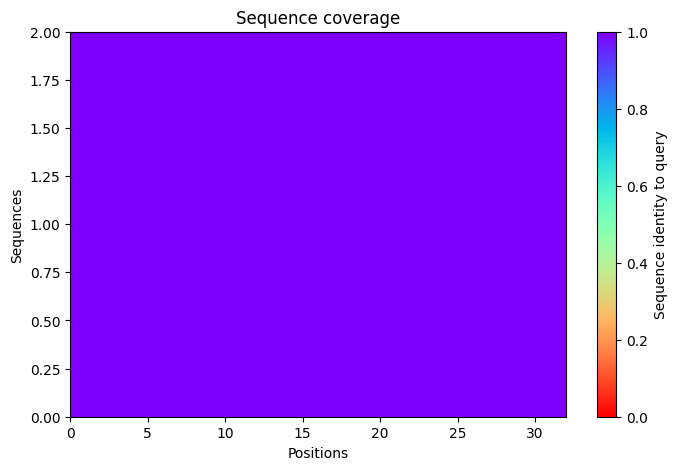

2024-09-12 17:38:36,354 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=53.3 pTM=0.204
2024-09-12 17:38:44,000 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=53.7 pTM=0.208 tol=0.834
2024-09-12 17:38:51,528 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=52.5 pTM=0.185 tol=0.792
2024-09-12 17:38:59,153 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=52.7 pTM=0.177 tol=0.169
2024-09-12 17:38:59,154 alphafold2_multimer_v3_model_1_seed_000 took 54.6s (3 recycles)


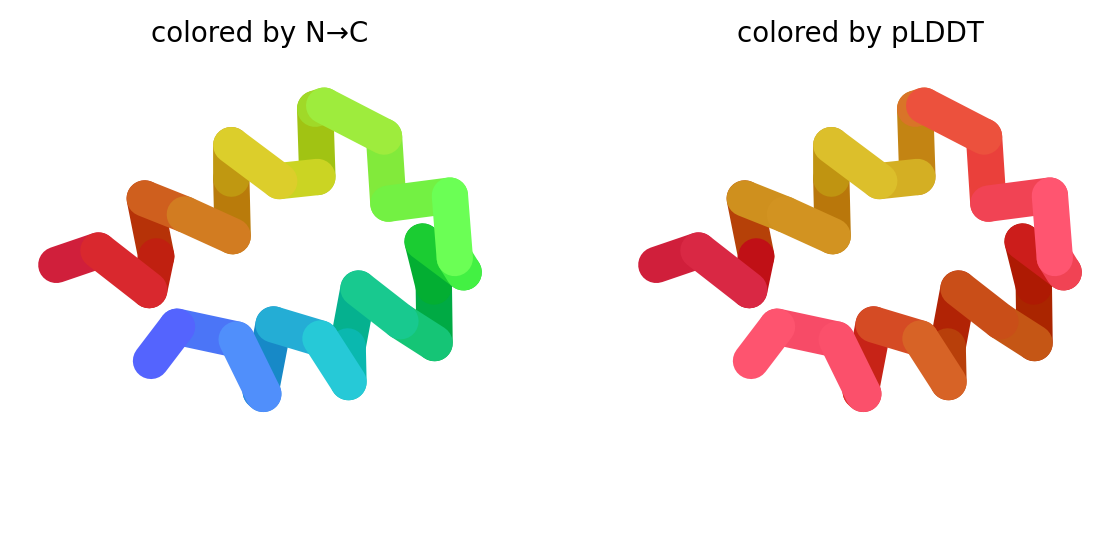

2024-09-12 17:39:06,988 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=53.2 pTM=0.179
2024-09-12 17:39:14,494 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=64.6 pTM=0.283 tol=0.843
2024-09-12 17:39:22,144 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=68.3 pTM=0.317 tol=0.235
2024-09-12 17:39:22,145 alphafold2_multimer_v3_model_2_seed_000 took 22.8s (2 recycles)


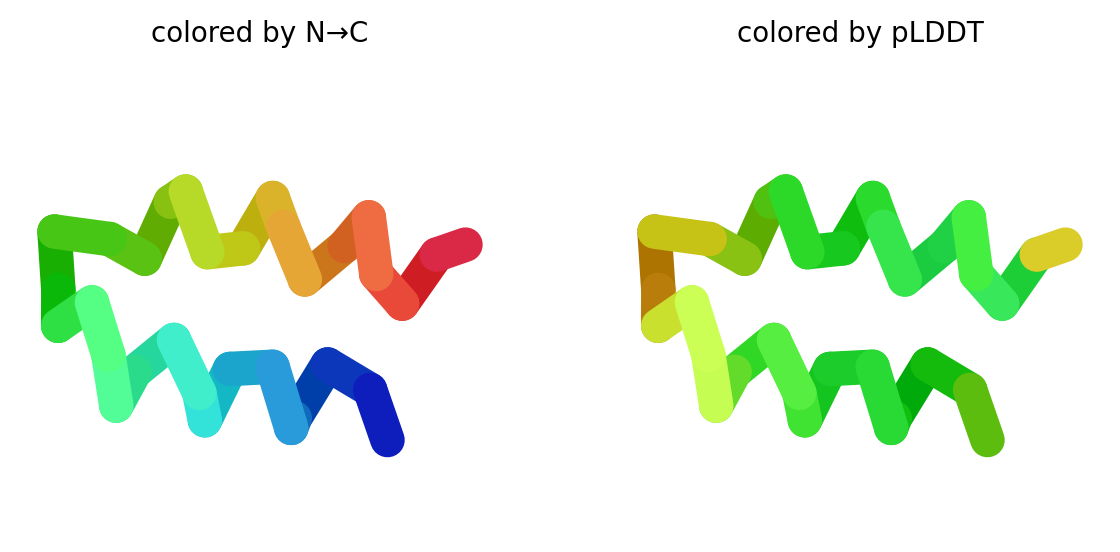

2024-09-12 17:39:29,831 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=44.4 pTM=0.14
2024-09-12 17:39:37,518 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=58.8 pTM=0.258 tol=2.39
2024-09-12 17:39:45,194 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=61.8 pTM=0.278 tol=0.521
2024-09-12 17:39:52,770 alphafold2_multimer_v3_model_3_seed_000 recycle=3 pLDDT=66.9 pTM=0.333 tol=0.255
2024-09-12 17:39:52,771 alphafold2_multimer_v3_model_3_seed_000 took 30.5s (3 recycles)


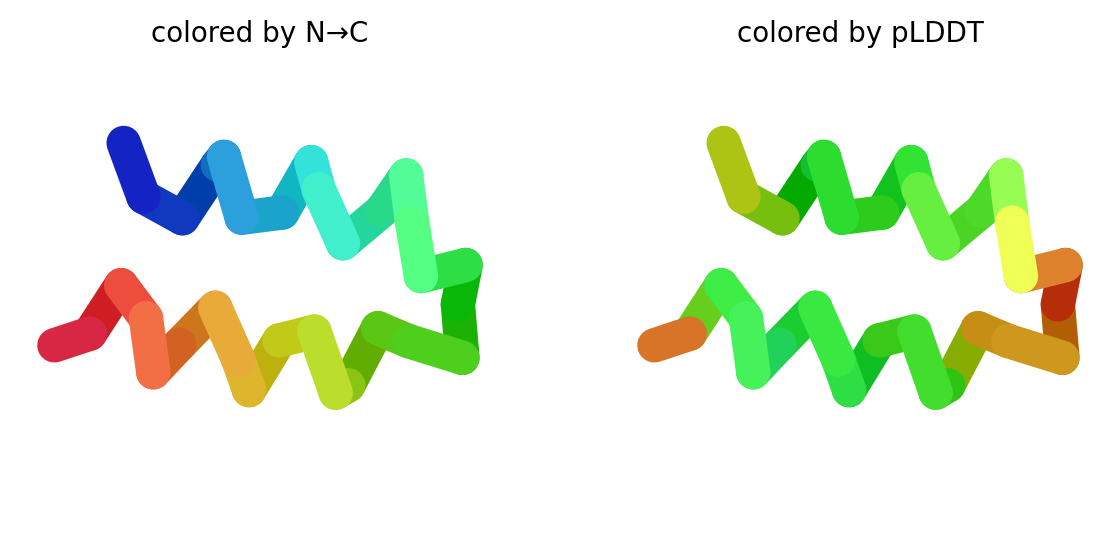

2024-09-12 17:40:00,664 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=42.6 pTM=0.11
2024-09-12 17:40:08,425 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=45.2 pTM=0.126 tol=2.68
2024-09-12 17:40:16,146 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=43.4 pTM=0.12 tol=1.69
2024-09-12 17:40:23,912 alphafold2_multimer_v3_model_4_seed_000 recycle=3 pLDDT=45.3 pTM=0.134 tol=2.41
2024-09-12 17:40:23,913 alphafold2_multimer_v3_model_4_seed_000 took 31.0s (3 recycles)


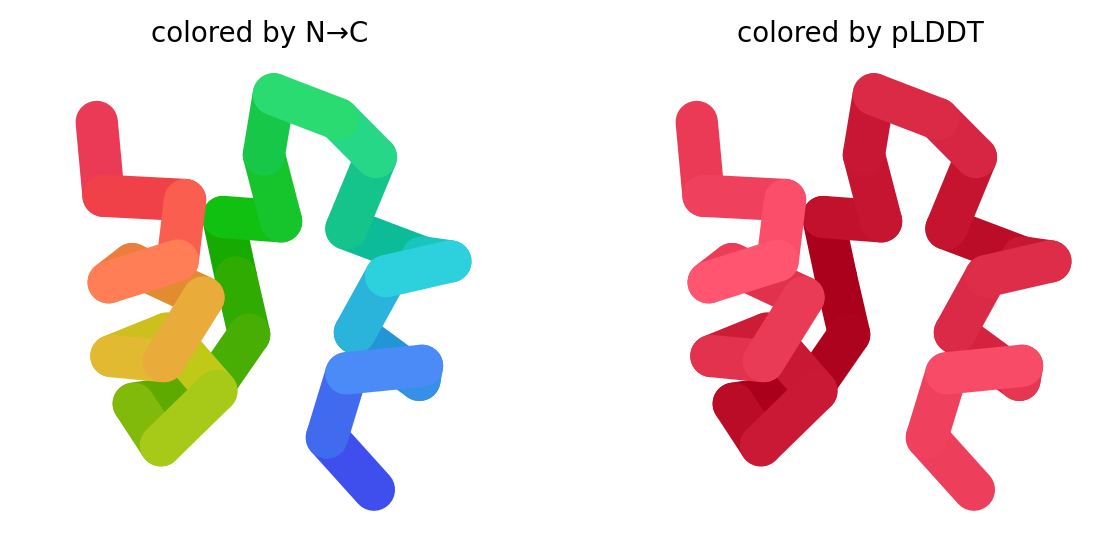

2024-09-12 17:40:31,705 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=39.1 pTM=0.101
2024-09-12 17:40:39,479 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=41.4 pTM=0.113 tol=1.75
2024-09-12 17:40:47,161 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=41.4 pTM=0.104 tol=1.45
2024-09-12 17:40:54,903 alphafold2_multimer_v3_model_5_seed_000 recycle=3 pLDDT=41.3 pTM=0.124 tol=3.47
2024-09-12 17:40:54,904 alphafold2_multimer_v3_model_5_seed_000 took 30.8s (3 recycles)


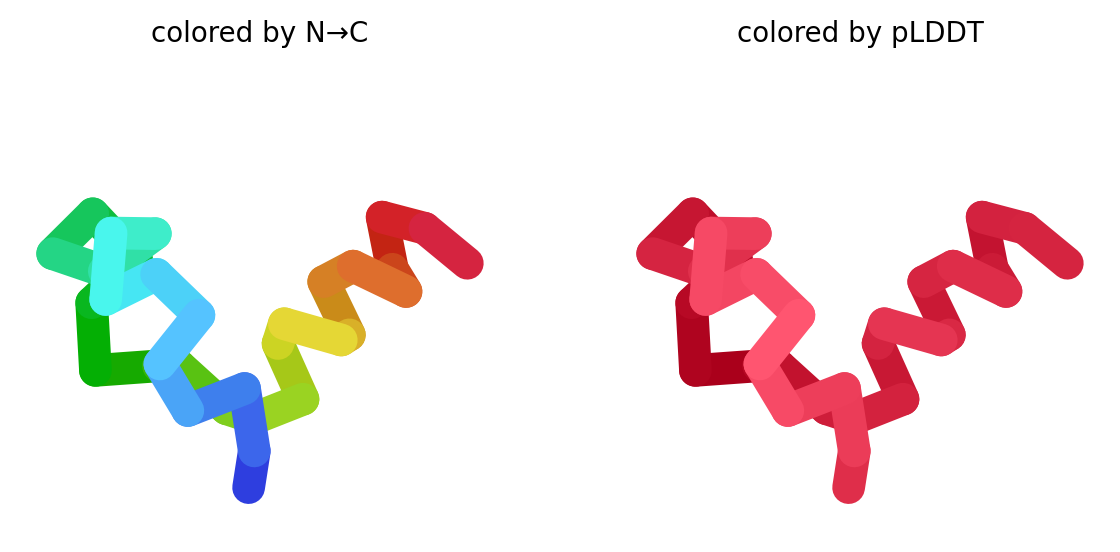

2024-09-12 17:40:55,065 reranking models by 'plddt' metric
2024-09-12 17:40:55,066 rank_001_alphafold2_multimer_v3_model_2_seed_000 pLDDT=68.3 pTM=0.317
2024-09-12 17:40:55,066 rank_002_alphafold2_multimer_v3_model_3_seed_000 pLDDT=66.9 pTM=0.333
2024-09-12 17:40:55,066 rank_003_alphafold2_multimer_v3_model_1_seed_000 pLDDT=52.7 pTM=0.177
2024-09-12 17:40:55,067 rank_004_alphafold2_multimer_v3_model_4_seed_000 pLDDT=45.3 pTM=0.134
2024-09-12 17:40:55,067 rank_005_alphafold2_multimer_v3_model_5_seed_000 pLDDT=41.3 pTM=0.124
2024-09-12 17:40:56,480 Query 2/2: seq2 (length 32)


PENDING:   0%|          | 0/150 [elapsed: 00:01 remaining: ?]

2024-09-12 17:40:57,507 Sleeping for 5s. Reason: PENDING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:08 remaining: 00:00]


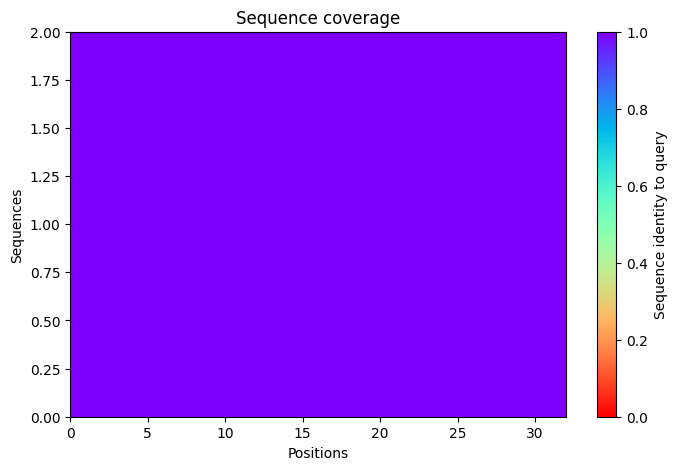

2024-09-12 17:41:13,147 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=46.2 pTM=0.129
2024-09-12 17:41:20,827 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=47 pTM=0.13 tol=0.983
2024-09-12 17:41:28,618 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=47.6 pTM=0.129 tol=0.355
2024-09-12 17:41:28,619 alphafold2_multimer_v3_model_1_seed_000 took 23.3s (2 recycles)


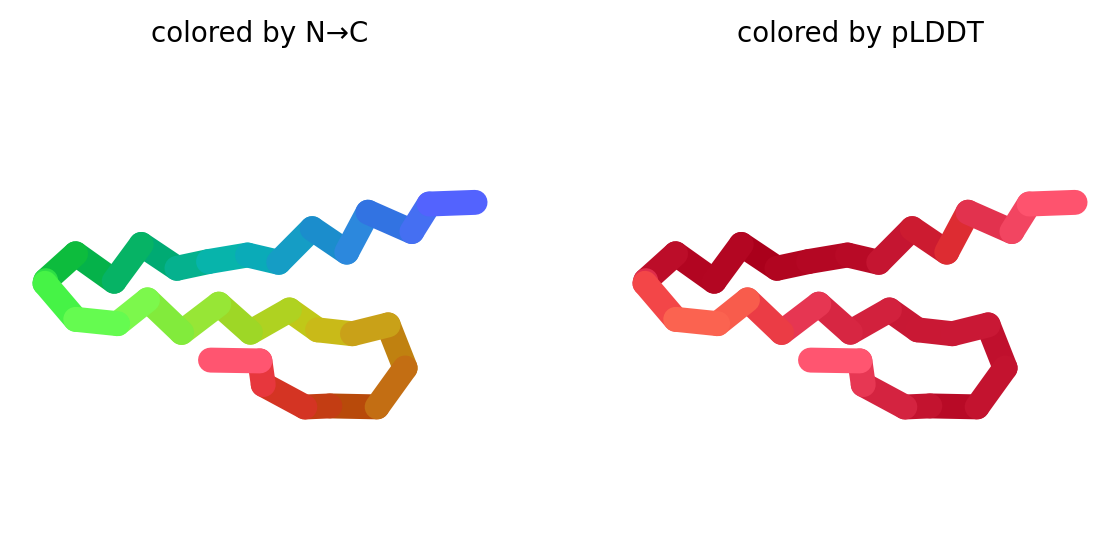

2024-09-12 17:41:36,453 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=40.3 pTM=0.101
2024-09-12 17:41:44,225 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=43.3 pTM=0.112 tol=1.37
2024-09-12 17:41:51,985 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=43.6 pTM=0.111 tol=0.271
2024-09-12 17:41:51,986 alphafold2_multimer_v3_model_2_seed_000 took 23.2s (2 recycles)


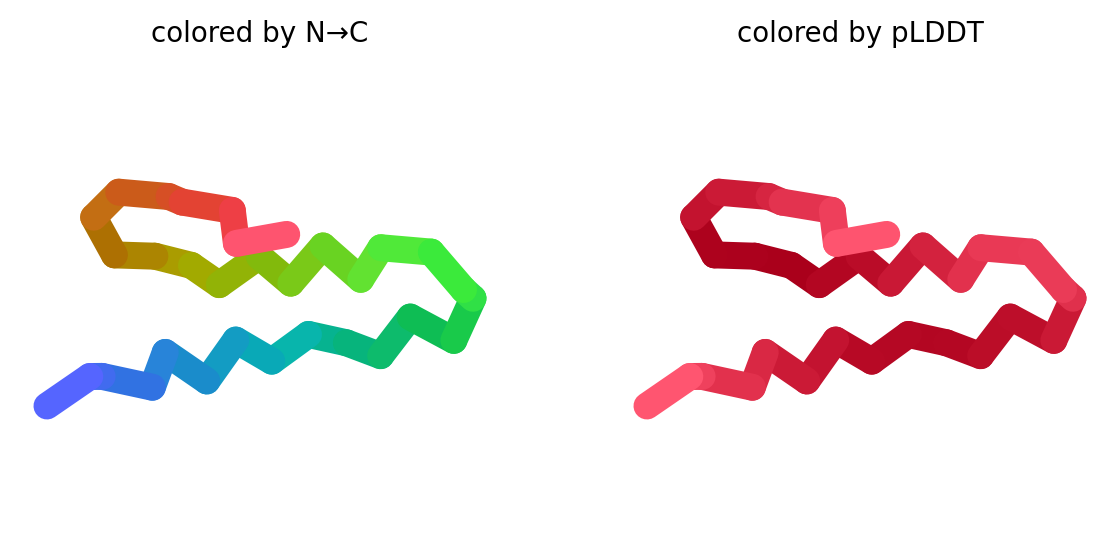

2024-09-12 17:41:59,763 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=50.8 pTM=0.199
2024-09-12 17:42:07,535 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=52.9 pTM=0.225 tol=0.561
2024-09-12 17:42:15,178 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=53.6 pTM=0.234 tol=0.326
2024-09-12 17:42:15,180 alphafold2_multimer_v3_model_3_seed_000 took 23.1s (2 recycles)


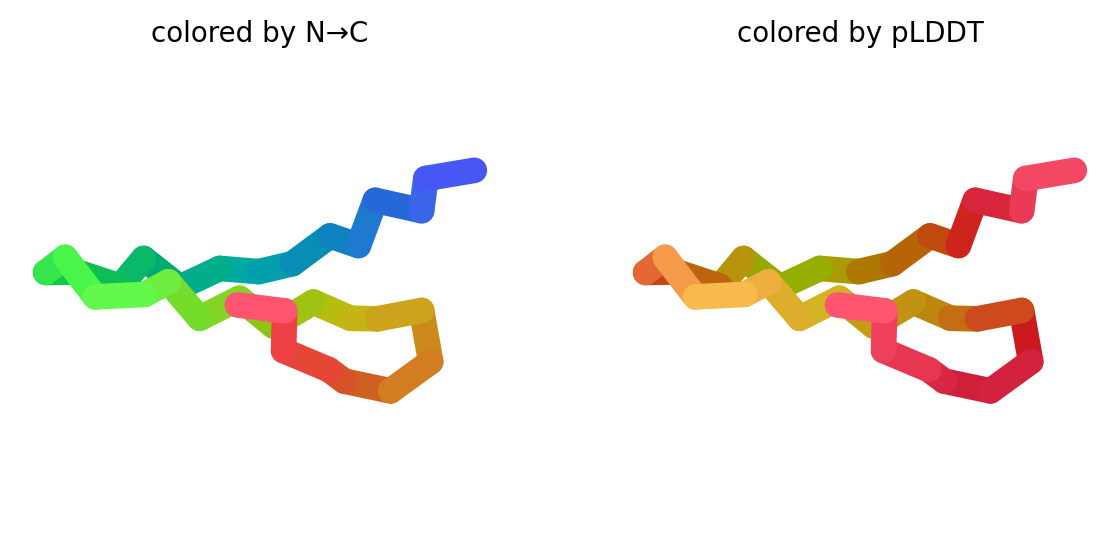

2024-09-12 17:42:23,174 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=47 pTM=0.16
2024-09-12 17:42:30,931 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=49 pTM=0.176 tol=0.632
2024-09-12 17:42:38,568 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=48.8 pTM=0.164 tol=0.348
2024-09-12 17:42:38,570 alphafold2_multimer_v3_model_4_seed_000 took 23.2s (2 recycles)


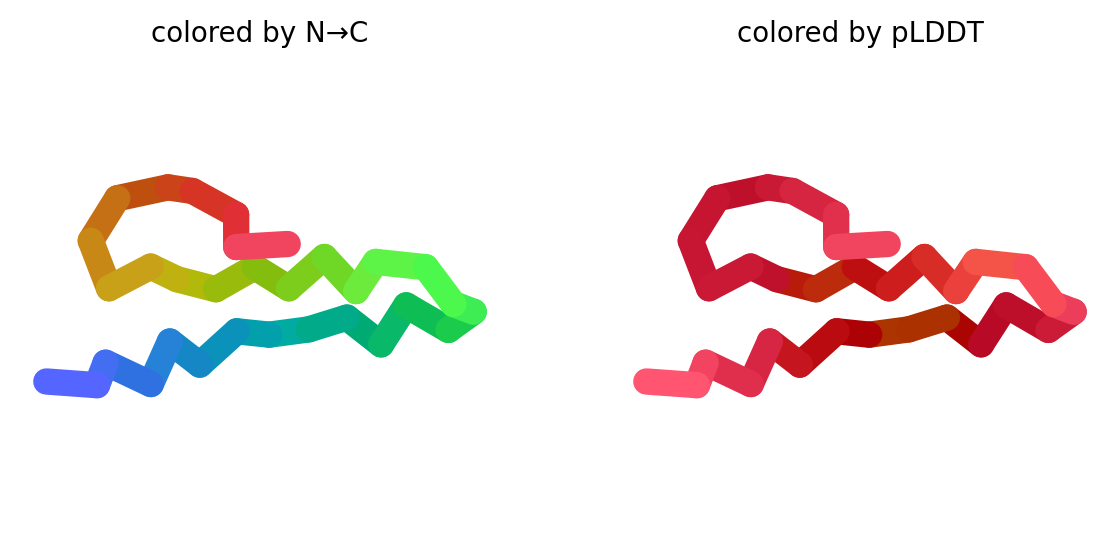

2024-09-12 17:42:46,679 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=44 pTM=0.15
2024-09-12 17:42:54,364 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=49.4 pTM=0.181 tol=0.873
2024-09-12 17:43:02,110 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=47.6 pTM=0.159 tol=0.528
2024-09-12 17:43:09,920 alphafold2_multimer_v3_model_5_seed_000 recycle=3 pLDDT=49.6 pTM=0.176 tol=0.551
2024-09-12 17:43:09,921 alphafold2_multimer_v3_model_5_seed_000 took 31.2s (3 recycles)


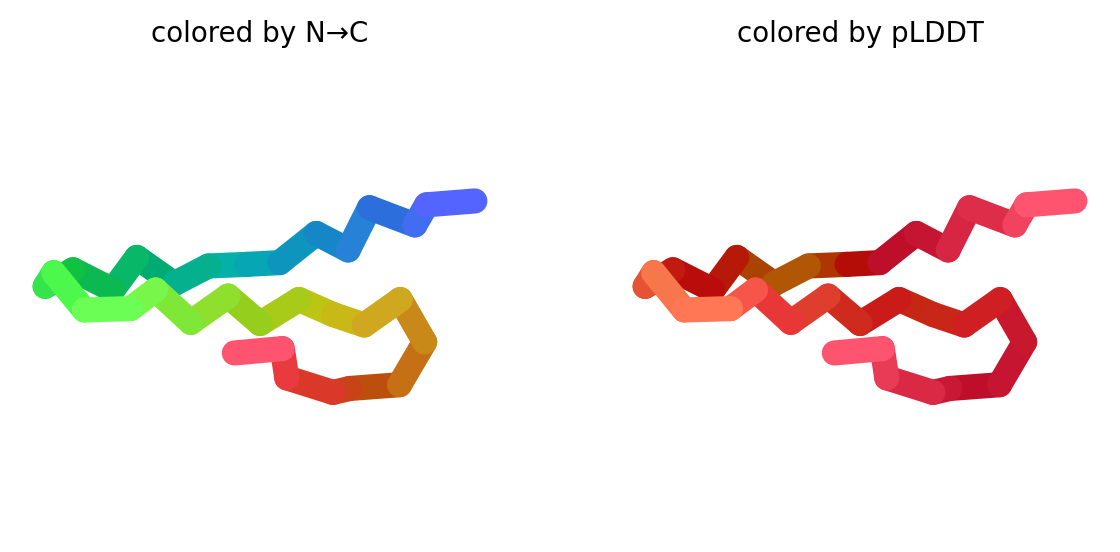

2024-09-12 17:43:10,053 reranking models by 'plddt' metric
2024-09-12 17:43:10,062 rank_001_alphafold2_multimer_v3_model_3_seed_000 pLDDT=53.6 pTM=0.234
2024-09-12 17:43:10,063 rank_002_alphafold2_multimer_v3_model_5_seed_000 pLDDT=49.6 pTM=0.176
2024-09-12 17:43:10,064 rank_003_alphafold2_multimer_v3_model_4_seed_000 pLDDT=48.8 pTM=0.164
2024-09-12 17:43:10,064 rank_004_alphafold2_multimer_v3_model_1_seed_000 pLDDT=47.6 pTM=0.129
2024-09-12 17:43:10,066 rank_005_alphafold2_multimer_v3_model_2_seed_000 pLDDT=43.6 pTM=0.111
2024-09-12 17:43:11,425 Done
Results saved and zipped to: test_job.result.zip


In [10]:
import sys
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
from colabfold.download import download_alphafold_params
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
from colabfold.colabfold import plot_protein
import numpy as np

# Function to run the prediction
def run_prediction(
    jobname: str,
    queries_path: str,
    model_type: str,
    msa_mode: str,
    num_relax: int,
    use_templates: bool,
    custom_template_path: Optional[str],
    num_recycles: Optional[int],
    relax_max_iterations: int,
    recycle_early_stop_tolerance: Optional[float],
    num_seeds: int,
    use_dropout: bool,
    pair_mode: str,
    pairing_strategy: str,
    max_msa: Optional[str],
    save_all: bool,
    save_recycles: bool,
    use_amber: bool,
    display_images: bool = True,
    dpi: int = 200,
    user_agent: str = "colabfold/google-colab-main"
):
    """
    Run the AlphaFold prediction with the given settings.

    Parameters:
    - jobname: The name of the job.
    - queries_path: Path to the CSV file containing queries.
    - model_type: The model type (e.g., "alphafold2_ptm", "alphafold2_multimer_v3").
    - msa_mode: MSA mode to use (e.g., "mmseqs2_uniref_env").
    - num_relax: Number of structures to relax using amber.
    - use_templates: Whether to use templates or not.
    - custom_template_path: Path to custom templates, if applicable.
    - num_recycles: Number of recycles for the model (can be "auto").
    - relax_max_iterations: Maximum amber relax iterations.
    - recycle_early_stop_tolerance: Tolerance for early stopping during recycling.
    - num_seeds: Number of seeds for sampling.
    - use_dropout: Whether to use dropout for uncertainty sampling.
    - pair_mode: Pairing mode for MSA (e.g., "unpaired_paired").
    - pairing_strategy: Pairing strategy for MSA (e.g., "greedy").
    - max_msa: Maximum MSA sequences to consider.
    - save_all: Whether to save all outputs.
    - save_recycles: Whether to save recycles.
    - use_amber: Whether to use amber for relaxation.
    - display_images: Whether to display images during prediction (default: True).
    - dpi: DPI for plotting images.
    - user_agent: User agent to send to the ColabFold API (default: "colabfold/google-colab-main").
    """

    # Suppress warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    from Bio import BiopythonDeprecationWarning
    warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

    # Check GPU type (e.g., Tesla K80), and adjust environment variables
    try:
        K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
    except:
        K80_chk = "0"
        pass

    if "1" in K80_chk:
        print("WARNING: found GPU Tesla K80: limited to total length < 1000")
        if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
            del os.environ["TF_FORCE_UNIFIED_MEMORY"]
        if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
            del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

    # For some reason we need this to get pdbfixer to import
    python_version = f"{sys.version_info.major}.{sys.version_info.minor}"
    if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
        sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

    # Callbacks for plotting and prediction
    def input_features_callback(input_features):
        if display_images:
            plot_msa_v2(input_features)
            plt.show()
            plt.close()

    def prediction_callback(protein_obj, length, prediction_result, input_features, mode):
        model_name, relaxed = mode
        if not relaxed and display_images:
            fig = plot_protein(protein_obj, Ls=length, dpi=dpi)
            plt.show()
            plt.close()

    # Set up logging
    result_dir = jobname
    log_filename = os.path.join(jobname, "log.txt")
    setup_logging(Path(log_filename))

    # Get the queries and determine if the input is a complex
    queries, is_complex = get_queries(queries_path)

    # Set the model type
    model_type = set_model_type(is_complex, model_type)

    # Check if cluster profile is needed
    if "multimer" in model_type and max_msa is not None:
        use_cluster_profile = False
    else:
        use_cluster_profile = True

    # Download AlphaFold parameters
    download_alphafold_params(model_type, Path("."))

    # Run the model
    results = run(
        queries=queries,
        result_dir=result_dir,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_relax=num_relax,
        msa_mode=msa_mode,
        model_type=model_type,
        num_models=5,
        num_recycles=num_recycles,
        relax_max_iterations=relax_max_iterations,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        model_order=[1, 2, 3, 4, 5],
        is_complex=is_complex,
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",
        pair_mode=pair_mode,
        pairing_strategy=pairing_strategy,
        stop_at_score=float(100),
        prediction_callback=prediction_callback,
        dpi=dpi,
        zip_results=False,
        save_all=save_all,
        max_msa=max_msa,
        use_cluster_profile=use_cluster_profile,
        input_features_callback=input_features_callback,
        save_recycles=save_recycles,
        user_agent=user_agent,
    )

    # Zip the results
    results_zip = f"{jobname}.result.zip"
    os.system(f"zip -r {results_zip} {jobname}")
    print(f"Results saved and zipped to: {results_zip}")

# -------------------------------------------
# Example usage:
# -------------------------------------------
if __name__ == "__main__":
    # Example parameters (adjust as needed)
    jobname = "test_job"
    queries_path = "./test_job/test_job.csv"
    model_type = "alphafold2_multimer_v3"
    msa_mode = "mmseqs2_uniref_env"
    num_relax = 0
    use_templates = False
    custom_template_path = None
    num_recycles = 3
    relax_max_iterations = 200
    recycle_early_stop_tolerance = 0.5
    num_seeds = 1
    use_dropout = False
    pair_mode = "unpaired_paired"
    pairing_strategy = "greedy"
    max_msa = None
    save_all = False
    save_recycles = False
    use_amber = False
    display_images = True
    dpi = 200

    # Run prediction
    run_prediction(
        jobname=jobname,
        queries_path=queries_path,
        model_type=model_type,
        msa_mode=msa_mode,
        num_relax=num_relax,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_recycles=num_recycles,
        relax_max_iterations=relax_max_iterations,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        pair_mode=pair_mode,
        pairing_strategy=pairing_strategy,
        max_msa=max_msa,
        save_all=save_all,
        save_recycles=save_recycles,
        use_amber=use_amber,
        display_images=display_images,
        dpi=dpi
    )


In [14]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
from typing import Optional

def show_pdb(
    results: dict,
    jobname: str,
    queries: list,
    rank_num: int = 1,
    show_sidechains: bool = False,
    show_mainchains: bool = False,
    color: str = "lDDT",
    is_complex: bool = False
):
    """
    Visualize a predicted protein structure using py3Dmol, matching PDB files based on rank.

    Parameters:
    - results: Dictionary containing the prediction results.
    - jobname: Name of the job (used for file paths).
    - queries: List of queries used to determine sequence names.
    - rank_num: The rank number of the model to display (default: 1).
    - show_sidechains: Whether to show sidechains (default: False).
    - show_mainchains: Whether to show mainchains (default: False).
    - color: Color scheme for the 3D model ("lDDT", "rainbow", or "chain").
    - is_complex: Flag indicating if the input is a protein complex (default: False).

    Returns:
    - view: The py3Dmol viewer object.
    """

    # Search for PDB files using glob
    pdb_files = glob.glob(f"{jobname}/*_unrelaxed_rank_00{rank_num}_*.pdb")

    # Print available files for debugging
    print(f"Available PDB files: {pdb_files}")

    # If no PDB file found, raise an error
    if len(pdb_files) == 0:
        raise FileNotFoundError(f"No PDB file found for rank {rank_num}. Tried matching: *_unrelaxed_rank_00{rank_num}_*.pdb")

    # Select the first PDB file that matches the pattern
    pdb_file = pdb_files[0]

    # Initialize py3Dmol viewer and load the pdb file
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    with open(pdb_file, 'r') as f:
        pdb_data = f.read()
    view.addModel(pdb_data, 'pdb')

    # Set the coloring scheme
    if color == "lDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    elif color == "rainbow":
        view.setStyle({'cartoon': {'color': 'spectrum'}})
    elif color == "chain":
        chains = len(queries[0][1]) + 1 if is_complex else 1
        for n, chain, color in zip(range(chains), alphabet_list, pymol_color_list):
            view.setStyle({'chain': chain}, {'cartoon': {'color': color}})

    # Show sidechains if requested
    if show_sidechains:
        BB = ['C', 'O', 'N']
        view.addStyle({'and': [{'resn': ["GLY", "PRO"], 'invert': True}, {'atom': BB, 'invert': True}]},
                      {'stick': {'colorscheme': 'WhiteCarbon', 'radius': 0.3}})
        view.addStyle({'and': [{'resn': "GLY"}, {'atom': 'CA'}]},
                      {'sphere': {'colorscheme': 'WhiteCarbon', 'radius': 0.3}})
        view.addStyle({'and': [{'resn': "PRO"}, {'atom': ['C', 'O'], 'invert': True}]},
                      {'stick': {'colorscheme': 'WhiteCarbon', 'radius': 0.3}})

    # Show mainchains if requested
    if show_mainchains:
        BB = ['C', 'O', 'N', 'CA']
        view.addStyle({'atom': BB}, {'stick': {'colorscheme': 'WhiteCarbon', 'radius': 0.3}})

    # Zoom to fit the model in the view
    view.zoomTo()

    # Return the py3Dmol viewer object
    return view


# Function to display the 3D structure with optional lDDT legend
def display_3d_structure(
    results: dict,
    jobname: str,
    msa_mode: str,
    queries: list,
    rank_num: int = 1,
    color: str = "lDDT",
    show_sidechains: bool = True,
    show_mainchains: bool = True,
    is_complex: bool = False
):
    """
    Display the 3D protein structure using py3Dmol and plot the lDDT legend if required.

    Parameters:
    - results: Dictionary containing the prediction results.
    - jobname: Name of the job (used for file paths).
    - msa_mode: Mode for MSA, used for setting jobname prefix.
    - queries: List of queries used to determine chain numbers (if required).
    - rank_num: The rank number of the model to display (default: 1).
    - color: Color scheme for the 3D model ("lDDT", "rainbow", or "chain").
    - show_sidechains: Whether to show sidechains (default: True).
    - show_mainchains: Whether to show mainchains (default: True).
    - is_complex: Flag indicating if the input is a protein complex (default: False).
    """

    # Show the 3D structure
    view = show_pdb(
        results=results,
        jobname=jobname,
        msa_mode=msa_mode,
        queries=queries,
        rank_num=rank_num,
        show_sidechains=show_sidechains,
        show_mainchains=show_mainchains,
        color=color,
        is_complex=is_complex
    )
    view.show()

    # Optionally display the lDDT legend if lDDT coloring is used
    if color == "lDDT":
        plot_plddt_legend().show()


In [16]:
# -------------------------------------------
# Example usage:
# -------------------------------------------
if __name__ == "__main__":
    # Example variables
    results = {"rank": [["1", "2", "3", "4", "5"]]}  # Simulating rank data from prediction
    jobname = "test_job"
    queries = [("seq1", "ACGTACGT"), ("seq2", "GGGTTTCCC")]
    rank_num = 2
    color = "rainbow"
    show_sidechains = False
    show_mainchains = True
    is_complex = False

    # Display the 3D structure
    try:
        view = show_pdb(
            results=results,
            jobname=jobname,
            queries=queries,
            rank_num=rank_num,
            show_sidechains=show_sidechains,
            show_mainchains=show_mainchains,
            color=color,
            is_complex=is_complex
        )
        view.show()
    except FileNotFoundError as e:
        print(e)

Available PDB files: ['test_job/seq2_unrelaxed_rank_002_alphafold2_multimer_v3_model_5_seed_000.pdb', 'test_job/seq1_unrelaxed_rank_002_alphafold2_multimer_v3_model_3_seed_000.pdb']


3Dmol.js failed to load for some reason. Please check your browser console for error messages.